In [ ]:
import os
os.chdir('..')
!pwd
import bilevel
from bilevel.build_all_models import *
from bilevel.OnlineLinearExpert import *
from bilevel.OnlineTreeExpert import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/krishna/Documents/Research/Simultaneous Classifier/folktables-experiments/multidecomp


In [ ]:
df_medical = pd.read_csv('./data_small/insurance.csv')

numeric_all = ['age', 'bmi', 'children', 'charges']
cat_all = ['sex', 'smoker', 'region']
df_medical_mm = numeric_scaler(df_medical, numeric_all)
df_medical_mm_oh = one_hot(df_medical_mm, cat_all)
df_medical_mm_oh.drop(cat_all, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_medical_mm_oh = df_medical_mm_oh * 1.0 # make bool true, false into 1.0, 0.0
df_medical_mm_oh.head()


A_t_age = pd.concat([df_medical['age'] <= 35,  # young
        (df_medical['age'] > 35) & (df_medical['age'] <= 50), # middle
        df_medical['age'] > 50], # old
             axis = 1, keys = ['young', 'middle', 'old'])


A_t_bmi = pd.concat([df_medical['bmi'] < 18.5,  # underweight
        (df_medical['bmi'] >= 18.5) & (df_medical['bmi'] < 25), # healthy
        (df_medical['bmi'] >= 25) & (df_medical['bmi'] < 30), # overweight
        df_medical['bmi'] >= 30],  # obese
             axis = 1, keys = ['underweight', 'healthyweight', 'overweight', 'obese'])   

A_t_smoker = pd.concat([df_medical['smoker'] == 'yes', df_medical['smoker'] == 'no'], axis = 1, keys = ['smoker', 'non-smoker'])


A_t_sex = pd.concat([df_medical['sex'] == 'male', df_medical['sex'] == 'female'], axis = 1, keys = ['male', 'female'])

A_t_medical_groups = pd.concat([A_t_age, A_t_bmi, A_t_smoker, A_t_sex], axis=1)
A_t_medical_groups['always_on'] = True
A_t_medical_groups *= 1.0
A_t_medical_groups.sum(axis=0)

young             574.0
middle            408.0
old               356.0
underweight        20.0
healthyweight     225.0
overweight        386.0
obese             707.0
smoker            274.0
non-smoker       1064.0
male              676.0
female            662.0
always_on        1338.0
dtype: float64

In [ ]:
from bilevel.Groupwise_seedruns import Groupwise_over_seeds
plot_ob = Groupwise_over_seeds(df_medical_mm_oh, 'charges', A_t_medical_groups)
plot_ob.build_all_seeds()
plot_ob.build_df_res()

100%|██████████| 1338/1338 [00:00<00:00, 4781.37it/s]


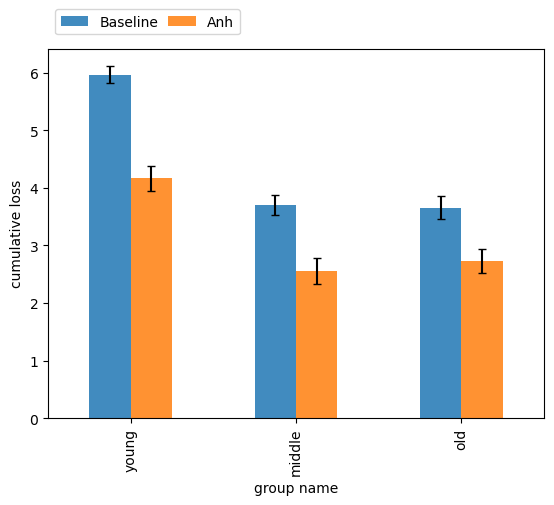

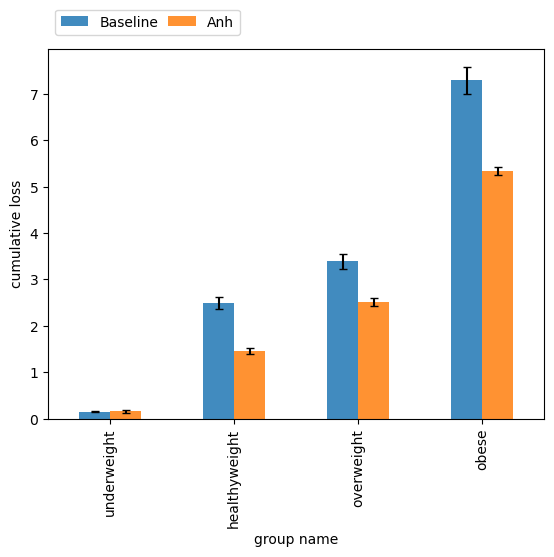

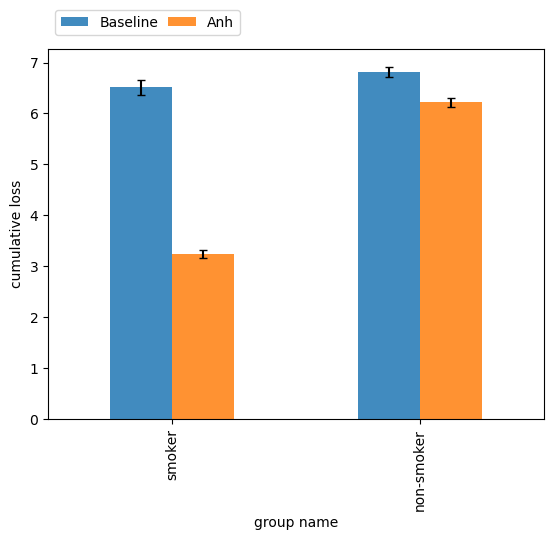

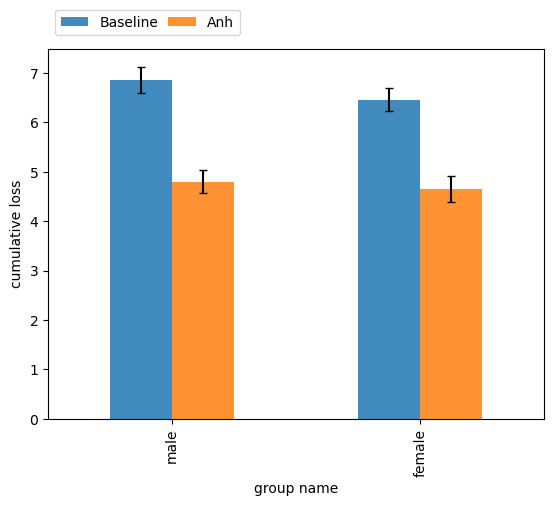

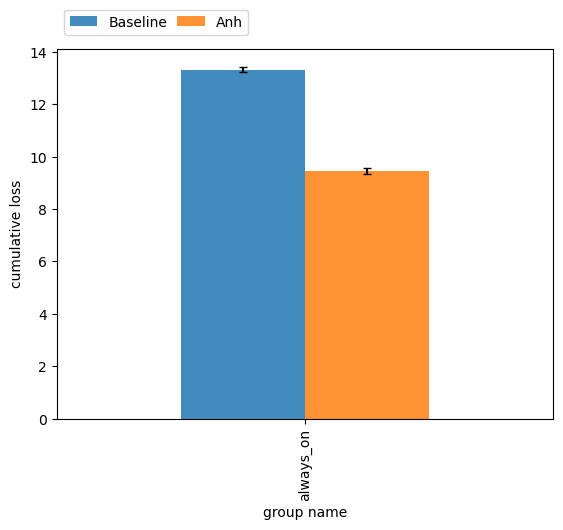

In [ ]:
subgroups_list = [['young', 'middle', 'old'], ['underweight', 'healthyweight', 'overweight',
       'obese'], ['smoker', 'non-smoker'], ['male', 'female'], ['always_on']]
plot_ob.plot_subgroups(subgroups_list)

In [ ]:
plot_ob.build_regret_curve()

young 574


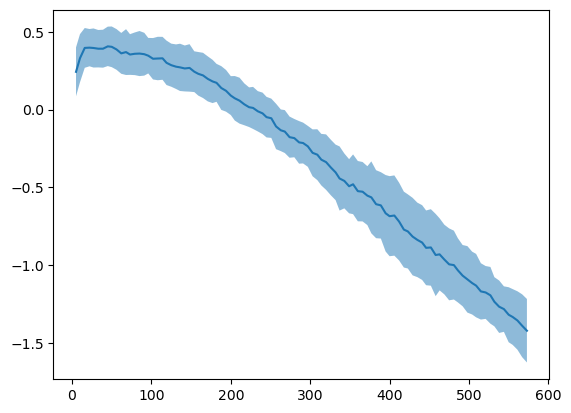

middle 408


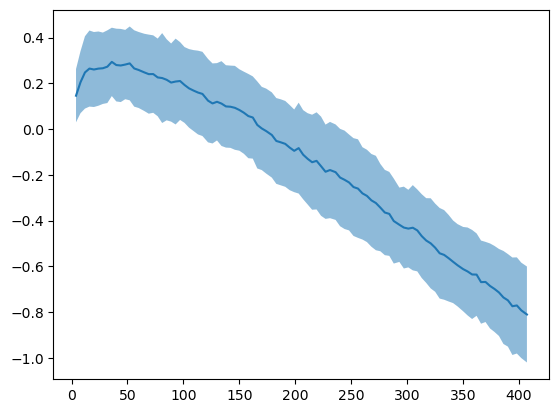

old 356


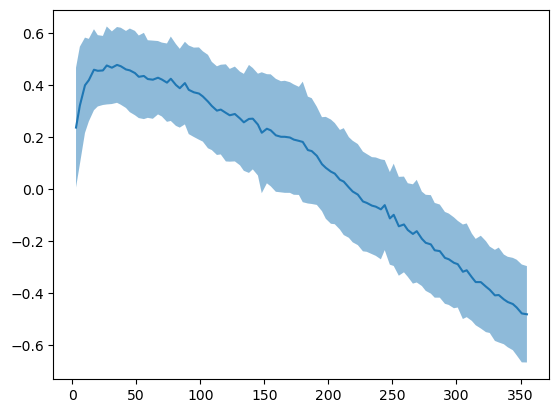

underweight 20


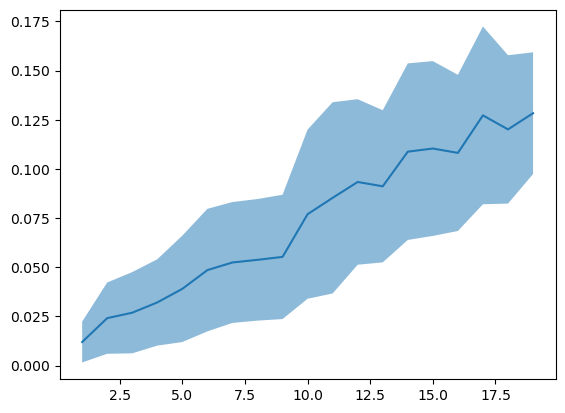

healthyweight 225


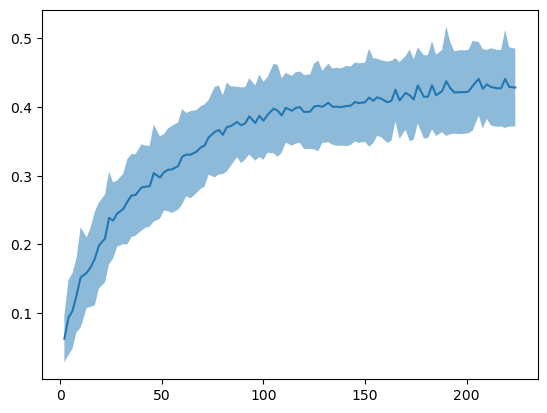

overweight 386


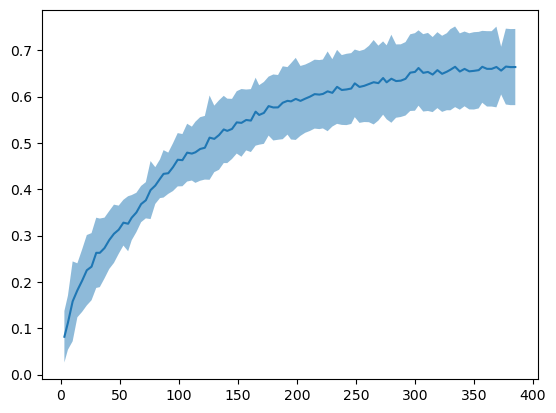

obese 707


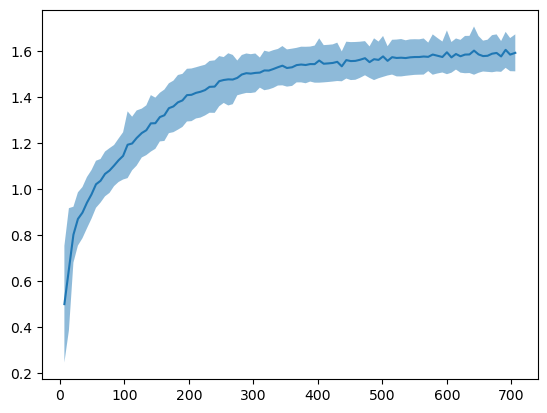

smoker 274


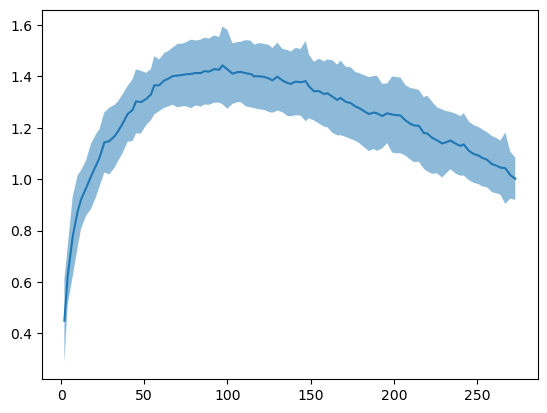

non-smoker 1064


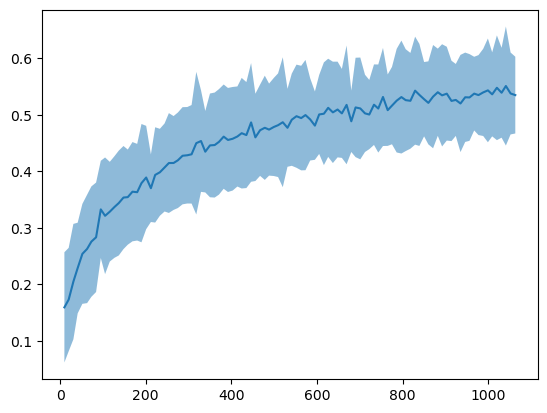

male 676


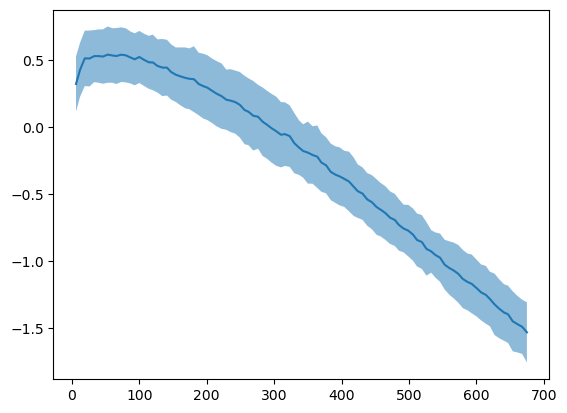

female 662


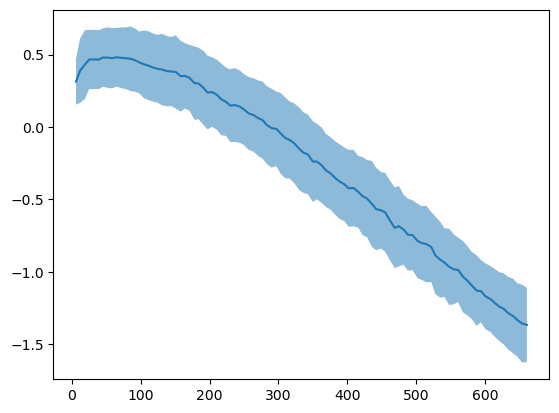

always_on 1338


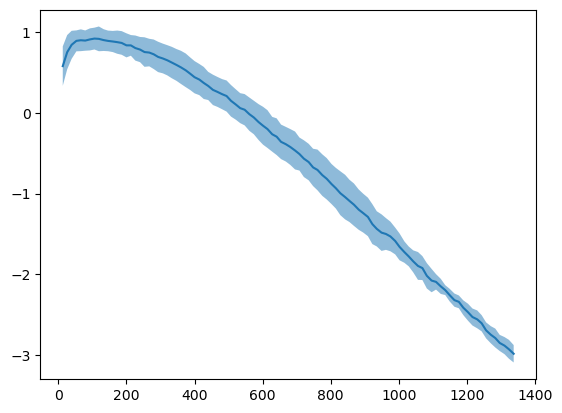

In [ ]:
plot_ob.plot_regret_curve_with_std() # using scipy

young 574


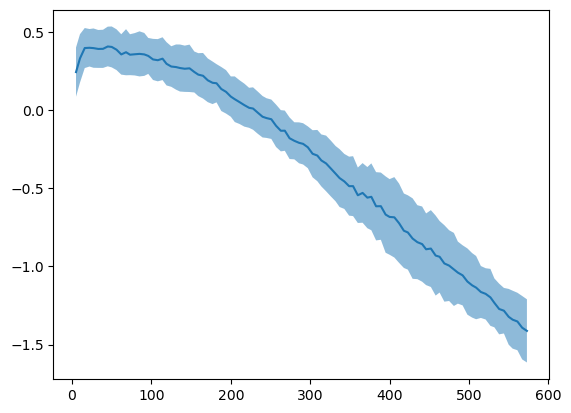

middle 408


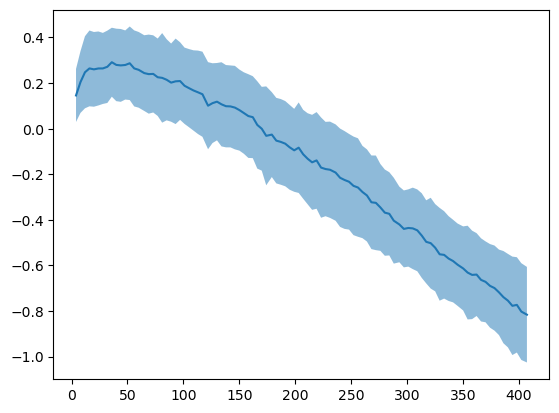

old 356


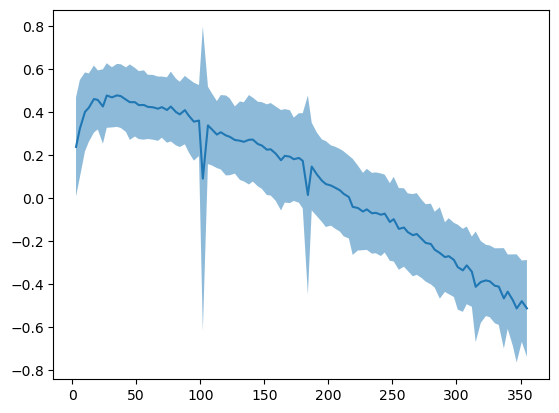

underweight 20


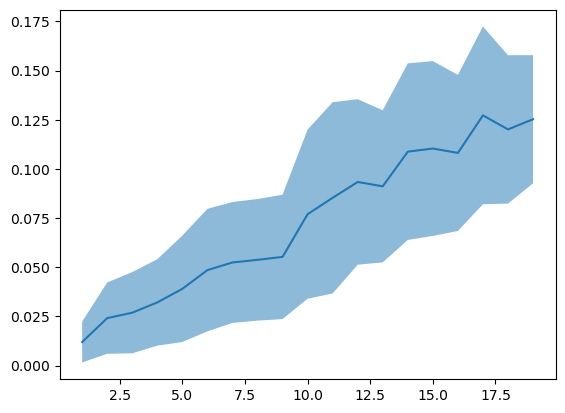

healthyweight 225


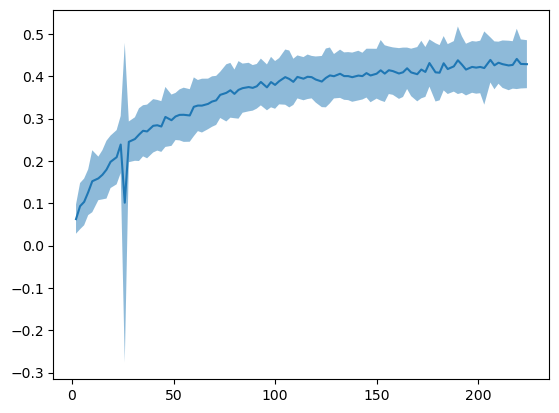

overweight 386


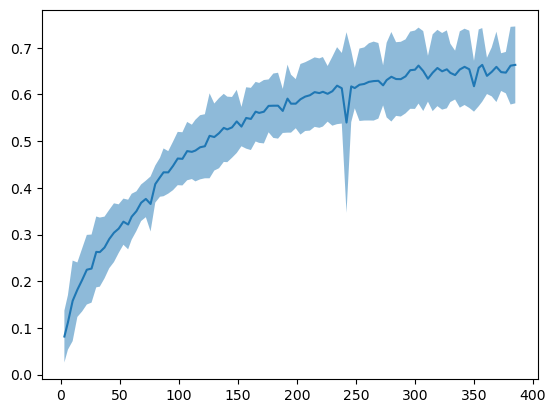

obese 707


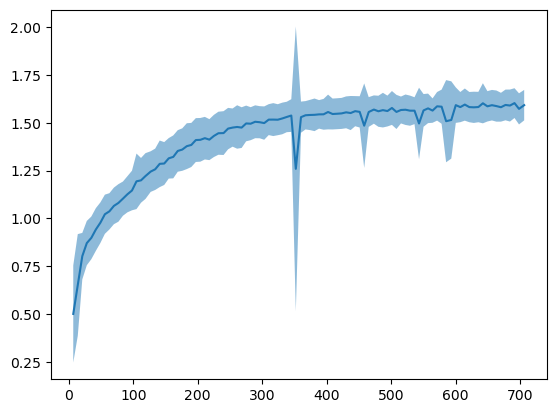

smoker 274


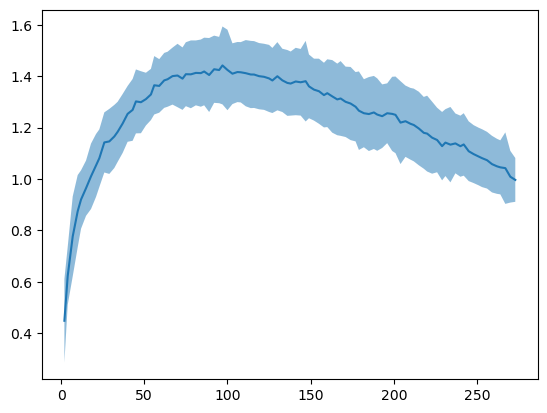

non-smoker 1064


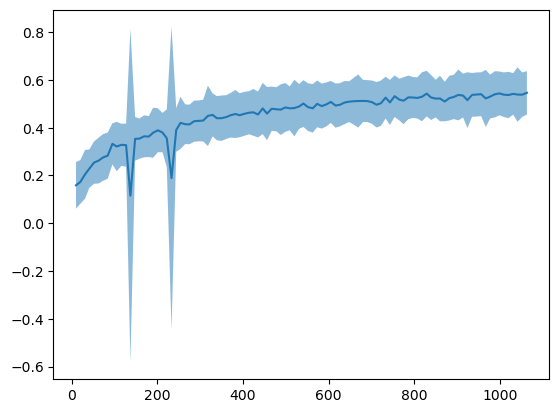

male 676


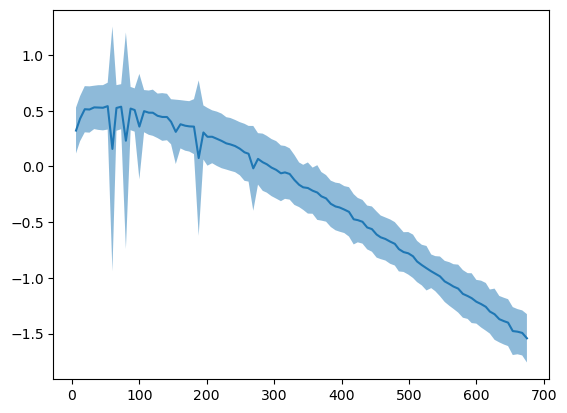

female 662


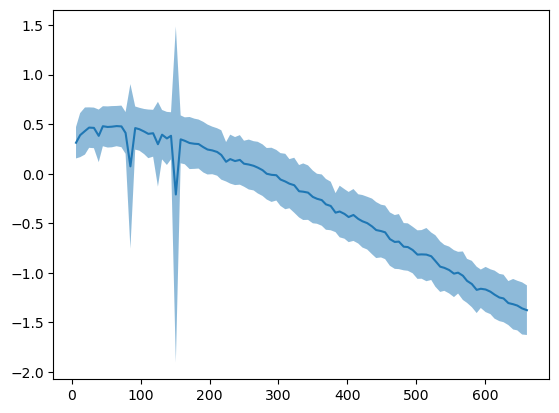

always_on 1338


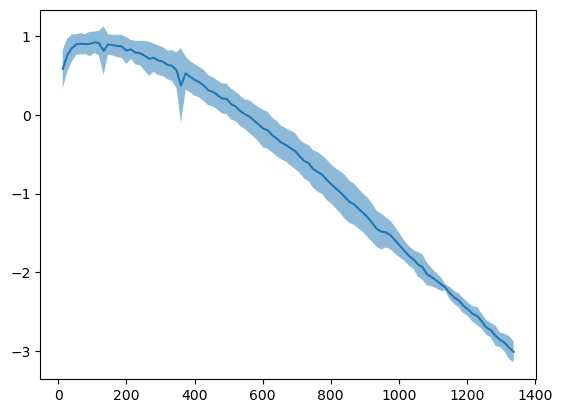

In [7]:
plot_ob.plot_regret_curve_with_std() # using scikit learn, more spiky